In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from os import path
from sklearn.decomposition import PCA
import sklearn
from glob import glob
import codecs
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
class Text(): 
    def __init__(self, filename, topWords, chunkSize=5000, maxPieces=1, 
                 equalPieces=False, maxLen=False): 
        with codecs.open(filename, "r",encoding='utf-8', errors='ignore') as fdata:
            self.raw = fdata.read().lower()
        self.name = path.splitext(path.basename(filename))[0]
        
        # Use the filename to generate metadata like author name and date of publication. 
        # This assumes files named like austen-1811-mansfield.txt
        nameParts = self.name.split('-')
        self.author = nameParts[0]
        self.date = nameParts[1]
        
        self.tokens = nltk.tokenize.word_tokenize(self.raw) 
        
        if equalPieces: 
            # Break up the text into N equal-sized chunks, where n=maxPieces. 
            # Truncate the text at maxLen. 
            self.pieces = self.getEqualPieces(self.tokens, maxPieces, maxLen)
        else: 
            self.pieces = self.getPieces(self.tokens, chunkSize, maxPieces)

        # self.tokens = [word for word in self.tokens if word.isalpha()] # strip punctuation
        self.numPieces = len(self.pieces)
        self.chunkSize = len(self.pieces[0])
        
        if topWords:
            self.freqDists = []
            for piece in self.pieces: 
                mc = nltk.FreqDist(piece).most_common(topWords)
                d = {item[0]: item[1] for item in mc}
                self.freqDists.append(d)
        else: 
            self.freqDists = [nltk.FreqDist(piece) for piece in self.pieces]
        dfIndex = [self.name + '-' + str(i) for i in range(self.numPieces)]
        self.df = pd.DataFrame(self.freqDists, index=dfIndex).fillna(0)
        
        # I can't figure out how to get sklearn to CountVectorize on already-tokenized text, so 
        # putting this on hold for now. 
        #vectorizer = CountVectorizer(input='filename')
        #countMatrix = vectorizer.fit_transform(self.pieces).todense()
        #wordLabels = vectorizer.get_feature_names()
        #self.df = pd.DataFrame(countMatrix, columns=matrixLabels, index=textList)
        
    def __repr__(self): 
        return "Text %s: %s pieces of %s words each" % (self.name, self.numPieces, self.chunkSize)
    
    def __len__(self): 
        return len(self.tokens)
    
    def getPieces(self, text, length, num): 
        """ Chunk a text into `num` chunks of size `length`."""
        out = [] 
        for x in range(num): 
            out.append(text[length*x:length*(x+1)])
        return out
    
    def getEqualPieces(self, text, num, maxLen): 
        """ Divide a text into `num` equal pieces, also truncating at maxLen. """
        truncated = text[:maxLen]
        length = len(truncated)
        pieceSize = round(length / num)
        return self.getPieces(text, pieceSize, num)

In [8]:
class TextComparison(): 
    def __init__(self, filenames, numPieces=2, topWords=100):
        self.texts = [Text(filename, topWords=topWords) for filename in filenames]

        # Determine text with lowest word count. 
        # Truncate all other texts to this value. 
        cutoff = min(self.wordCounts.values())
        
        # TODO: make this so it doesn't have to instantiate a whole new text object each time. 
        # Maybe just get the word count some other way. 
        self.texts = [Text(filename, topWords=topWords, maxPieces=numPieces, equalPieces=True, maxLen=cutoff) 
                      for filename in filenames]
        
        self.dfs = [text.df for text in self.texts]
        self.df = pd.concat(self.dfs).fillna(0)
        self.labels = list(self.df.index)
        self.dates = [int(text.date) for text in self.texts]
        
    @property
    def pieceDates(self):
        dateList = []
        for text in self.texts: 
            theseDates = [int(text.date)] * text.numPieces
            dateList += theseDates
        return dateList

    @property
    def colors(self, by='date'): 
        if by == 'text': 
            colors = ['red', 'blue', 'green', 'yellow', 'purple'] * 10
            fullColorVec = []
            for i, text in enumerate(self.texts): 
                colorVec = [colors[i]] * text.numPieces
                fullColorVec += colorVec
        if by == 'date':    
            fullColorVec = plt.cm.rainbow(self.rescale(self.pieceDates, 0, 1))
        return fullColorVec
    
    def rescale(self, array, low, high):
        minimum = min(array)
        maximum = max(array)
        diff = maximum - minimum
        diffScale = high - low
        return list(map( lambda x: (int(x)-minimum)*(diffScale/diff)+low, array))
    
    @property
    def size(self, by='date'): 
        if by == 'date': 
            return self.rescale(self.pieceDates, 20, 500)

    @property
    def wordCounts(self): 
        wordCountsDict = {text.name: len(text) for text in self.texts} 
        #pd.Series(wordCountsDict).plot(kind='bar')
        return wordCountsDict
    
    def doPCA(self, labels=False, saveTo=False): 
        pca = PCA(n_components=2)
        pcaTable = pca.fit_transform(self.df)
        Xs = [thing[0] for thing in pcaTable]
        Ys = [thing[1] for thing in pcaTable]
        df = pd.DataFrame(pcaTable, index=self.labels)
        df['distance'] = np.sqrt(df[0]**2 + df[1]**2)     # Pythagorean theorem   
        ax = plt.scatter(df[0], df[1], s=self.size, color=self.colors)
        if labels: 
            for i, label in enumerate(self.labels):
                plt.annotate(label, (Xs[i], Ys[i]))
        if saveTo: 
            fig = ax.get_figure()
            fig.tight_layout()
            fig.savefig('pca-' + saveTo + '.png') # save it to a file
        return df.sort_values('distance', ascending=False).head()

# Thomas Mann

In [9]:
textList = glob('data/mann*')
t = TextComparison(textList)
textList

['data/mann-1903-tristan.txt',
 'data/mann-1903-tonio.txt',
 'data/mann-1897-kleine-herr.txt',
 'data/mann-1909-königliche.txt',
 'data/mann-1943-doktor.txt',
 'data/mann-1912-tod.txt',
 'data/mann-1902-gladius.txt',
 'data/mann-1901-buddenbrooks.txt']

,0,1,distance
hemingway-1940-for-whom-the-bell-1,777.578002,-310.753087,837.373890
hemingway-1940-for-whom-the-bell-0,732.158857,-359.839646,815.807062
hemingway-1952-old-man-and-the-sea-1,470.000746,483.108013,674.013393
hemingway-1952-old-man-and-the-sea-0,300.983285,424.574633,520.436891
hemingway-1926-sun-also-rises-1,-354.193971,-331.715049,485.271308


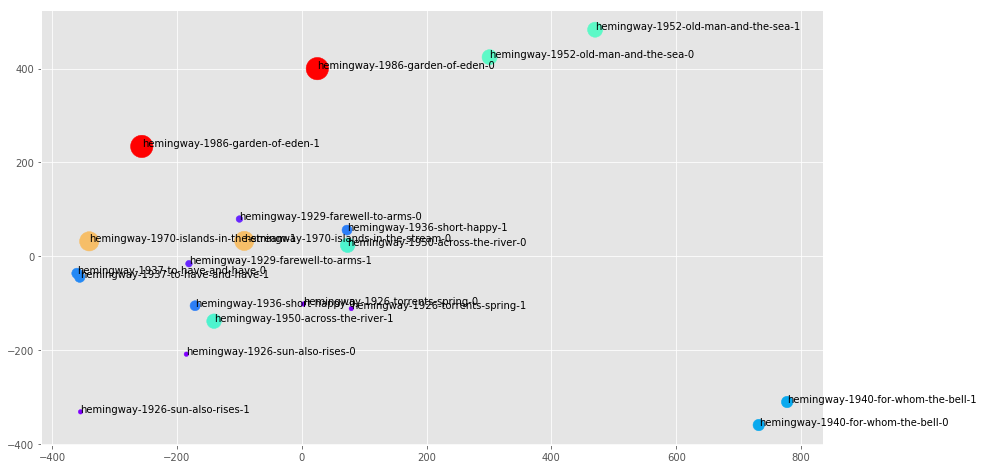

In [12]:
df = t.doPCA(labels=True)
df

# Marcel Proust

In [13]:
textList = glob('data/proust*')
t = TextComparison(textList)
textList

['data/proust-1920-guermantes.txt',
 'data/proust-1919-lombre.txt',
 'data/proust-1927-retrouve.txt',
 'data/proust-1923-prisonniere.txt',
 'data/proust-1921-sodome.txt',
 'data/proust-1925-albertine.txt',
 'data/proust-1913-swann.txt']

,0,1,distance
proust-1925-albertine-0,1218.883714,-203.294162,1235.720852
proust-1923-prisonniere-0,394.899730,527.083238,658.606511
proust-1923-prisonniere-1,-146.087649,564.522948,583.118993
proust-1913-swann-1,-396.858391,-381.442129,550.449526
proust-1921-sodome-0,-356.982654,362.140027,508.509601


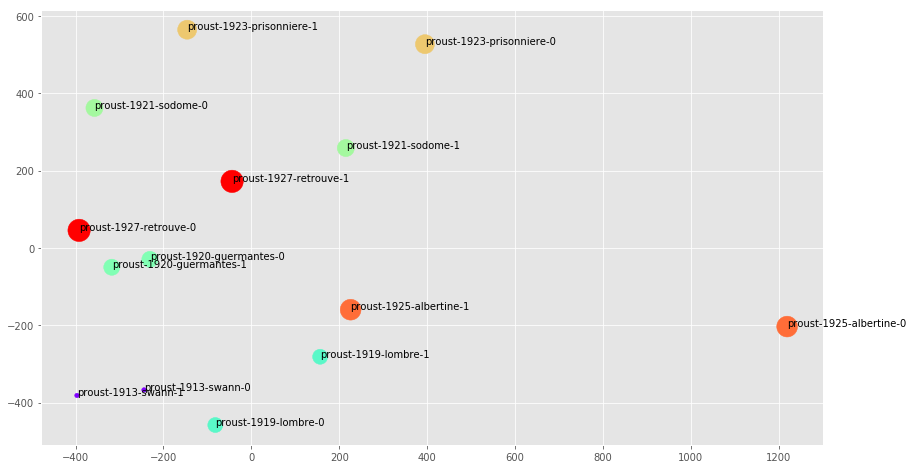

In [14]:
df = t.doPCA(labels=True)
df

# Arnold Bennett

In [15]:
textList = glob('data/bennett*')
t = TextComparison(textList)
textList

['data/bennett-1923-riceyman.txt',
 'data/bennett-1916-these-twain.txt',
 'data/bennett-1928-strange-vanguard.txt',
 'data/bennett-1929-accident.txt',
 'data/bennett-1910-clayhanger.txt',
 'data/bennett-1911-card.txt',
 'data/bennett-1908-old-wives.txt',
 'data/bennett-1930-imperial.txt',
 'data/bennett-1902-anna.txt',
 'data/bennett-1902-grand-babylon.txt']

,0,1,distance
bennett-1910-clayhanger-0,1831.266780,-637.938382,1939.201743
bennett-1910-clayhanger-1,1617.798549,-912.341600,1857.320473
bennett-1902-grand-babylon-0,277.205253,1234.851195,1265.582959
bennett-1902-grand-babylon-1,332.288596,1209.293445,1254.115763
bennett-1902-anna-1,269.051728,1183.546827,1213.742940


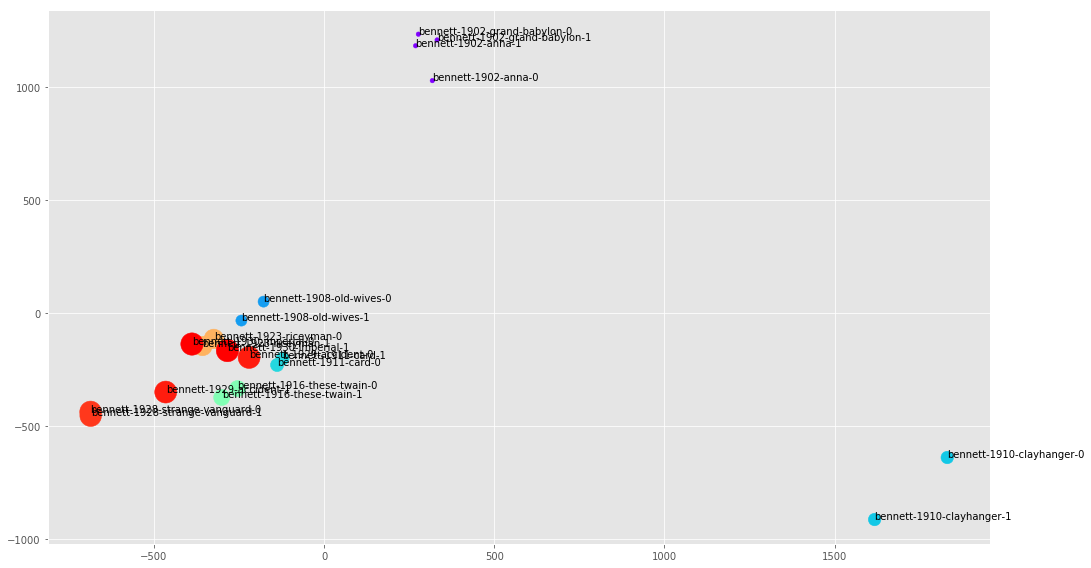

In [16]:
df = t.doPCA(labels=True, saveTo='bennett-2')
df

# Mary Augusta Ward (Mrs. Humphry Ward)

In [17]:
textList = glob('data/ward*')
t = TextComparison(textList)
textList

['data/ward-1913-mating.txt',
 'data/ward-1917-missing.txt',
 'data/ward-1900-eleanor.txt',
 'data/ward-1888-robert.txt',
 'data/ward-1915-success.txt',
 'data/ward-1908-diana.txt',
 'data/ward-1881-milly.txt',
 'data/ward-1903-lady-rose.txt',
 'data/ward-1916-connie.txt',
 'data/ward-1892-grieve.txt',
 'data/ward-1898-helbeck.txt',
 'data/ward-1896-tressady.txt',
 'data/ward-1920-harvest.txt',
 'data/ward-1894-marcella.txt',
 'data/ward-1905-marriage.txt']

,0,1,distance
ward-1881-milly-0,-404.596312,518.958993,658.039977
ward-1888-robert-1,509.411974,270.602801,576.824441
ward-1881-milly-1,-231.475069,492.489367,544.175049
ward-1900-eleanor-0,420.663496,-340.238674,541.036166
ward-1892-grieve-0,484.829382,197.966330,523.689027


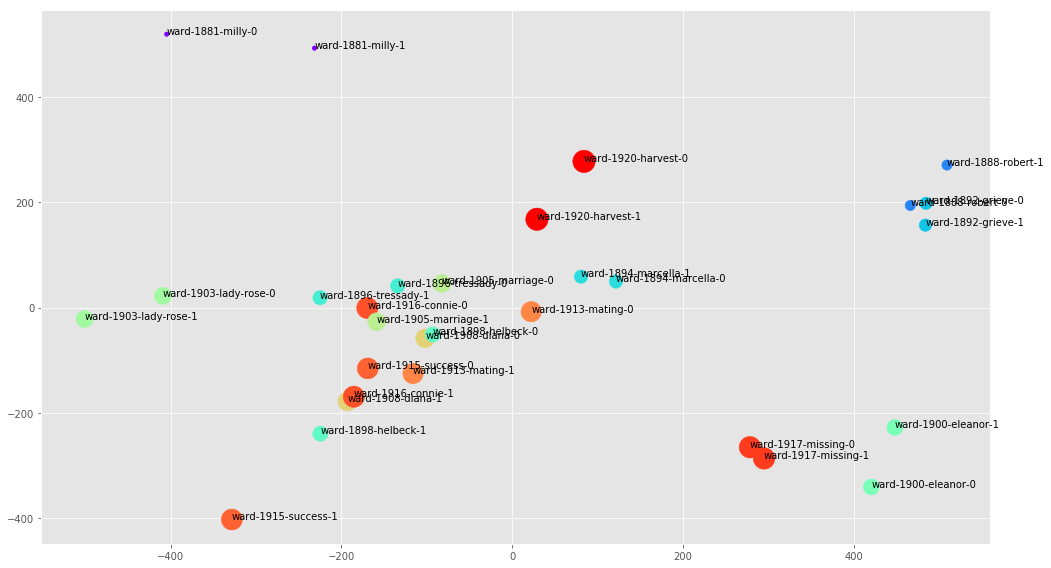

In [18]:
df = t.doPCA(labels=True, saveTo='ward-nomilly')
df

# Anthony Trollope

In [19]:
textList = glob('data/trollope*')
t = TextComparison(textList)
textList

['data/trollope-1875-way-we-live.txt',
 'data/trollope-1855-warden.txt',
 'data/trollope-1877-american-senator.txt',
 'data/trollope-1884-old-man.txt',
 'data/trollope-1869-phineas.txt',
 'data/trollope-1858-doctor-thorne.txt',
 'data/trollope-1857-barchester.txt',
 'data/trollope-1883-landleaguers.txt',
 'data/trollope-1864-house-at.txt',
 'data/trollope-1865-can-you-forgive.txt',
 'data/trollope-1861-framley.txt',
 'data/trollope-1867-last-chronicle.txt']

,0,1,distance
trollope-1855-warden-0,1268.582803,-148.330117,1277.225176
trollope-1857-barchester-0,938.026670,538.555508,1081.635830
trollope-1855-warden-1,960.834213,-131.649874,969.811360
trollope-1877-american-senator-1,-877.857701,299.996680,927.702620
trollope-1884-old-man-1,-879.666158,-193.646563,900.728339


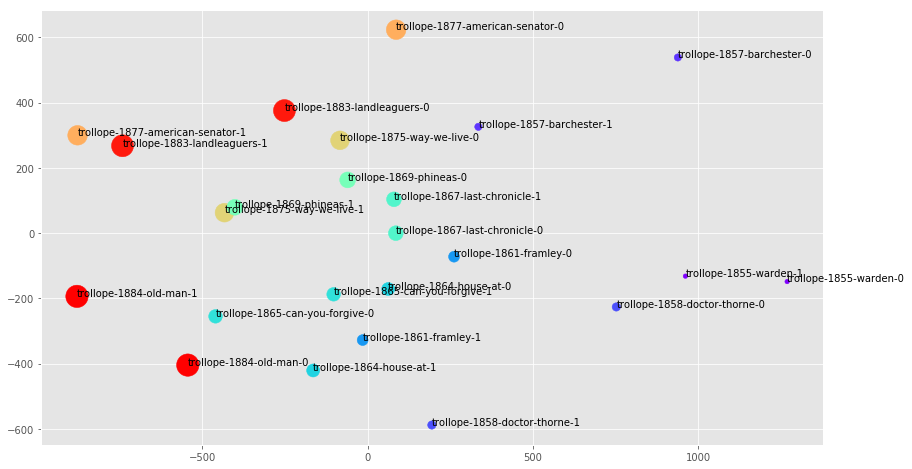

In [20]:
df = t.doPCA(labels=True)
df

# Wilkie Collins

In [21]:
textList = glob('data/collins*')
t = TextComparison(textList)
textList

['data/collins-1866-armadale.txt',
 'data/collins-1879-fallen-leaves.txt',
 'data/collins-1875-law-and-the-lady.txt',
 'data/collins-1885-evil-genius.txt',
 'data/collins-1870-man-and-wife.txt',
 'data/collins-1882-heart-and-science.txt',
 'data/collins-1868-the-moonstone.txt',
 'data/collins-1888-legacy-of-cain.txt',
 'data/collins-1860-woman-in-white.txt',
 'data/collins-1872-poor-miss-finch.txt',
 'data/collins-1886-guilty-river.txt',
 'data/collins-1862-no-name.txt',
 'data/collins-1854-hide-and-seek.txt',
 'data/collins-1876-two-destinies.txt',
 'data/collins-1874-dead-alive.txt',
 'data/collins-1881-black-robe.txt',
 'data/collins-1879-haunted-hotel.txt',
 'data/collins-1856-dead-secret.txt',
 'data/collins-1852-basil.txt',
 'data/collins-1873-new-magdalen.txt']

,0,1,distance
collins-1875-law-and-the-lady-1,-230.360087,379.630057,444.054895
collins-1888-legacy-of-cain-1,-240.087308,366.886329,438.460368
collins-1854-hide-and-seek-0,213.102741,-376.490710,432.617653
collins-1856-dead-secret-0,308.770643,-293.333403,425.891765
collins-1886-guilty-river-1,207.113563,356.038516,411.897381


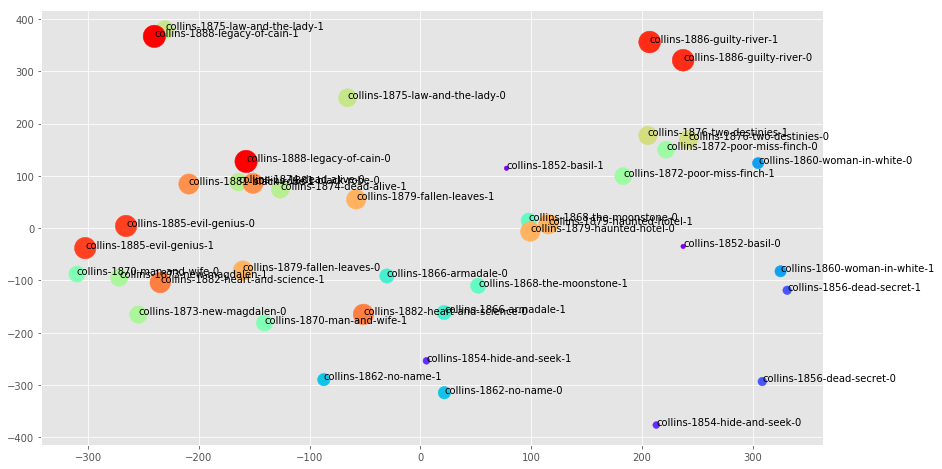

In [22]:
df = t.doPCA(labels=True)
df

# Walter Scott

In [23]:
textList = glob('data/scott*')
t = TextComparison(textList)
textList

['data/scott-1815-guy-mannering.txt',
 'data/scott-1825-talisman.txt',
 'data/scott-1828-maid-of-perth.txt',
 'data/scott-1829-anne.txt',
 'data/scott-1818-heart-of-midlothian.txt',
 'data/scott-1824-redgauntlet.txt',
 'data/scott-1814-waverly.txt',
 'data/scott-1832-count-robert.txt',
 'data/scott-1816-old-mortality.txt',
 'data/scott-1819-legend-of-montrose.txt',
 'data/scott-1816-black-dwarf.txt',
 'data/scott-1819-ivanhoe.txt',
 'data/scott-1820-the-abbot.txt',
 'data/scott-1823-quentin.txt',
 'data/scott-1821-pirate.txt',
 'data/scott-1816-antiquary.txt',
 'data/scott-1817-rob-roy.txt',
 'data/scott-1821-kenilworth.txt',
 'data/scott-1825-bethrothed.txt',
 'data/scott-1826-woodstock.txt',
 'data/scott-1823-st-ronans-well.txt',
 'data/scott-1819-bride-of-lammermoor.txt',
 'data/scott-1816-old-mortality.tt',
 'data/scott-1831-castle-dangerous.txt']

,0,1,distance
scott-1823-st-ronans-well-1,-353.956658,1049.564162,1107.641750
scott-1816-old-mortality-1,846.746351,264.552909,887.111957
scott-1816-antiquary-1,781.211022,388.036727,872.274706
scott-1817-rob-roy-1,705.388126,501.925332,865.737516
scott-1832-count-robert-0,-766.213967,-397.178856,863.038172


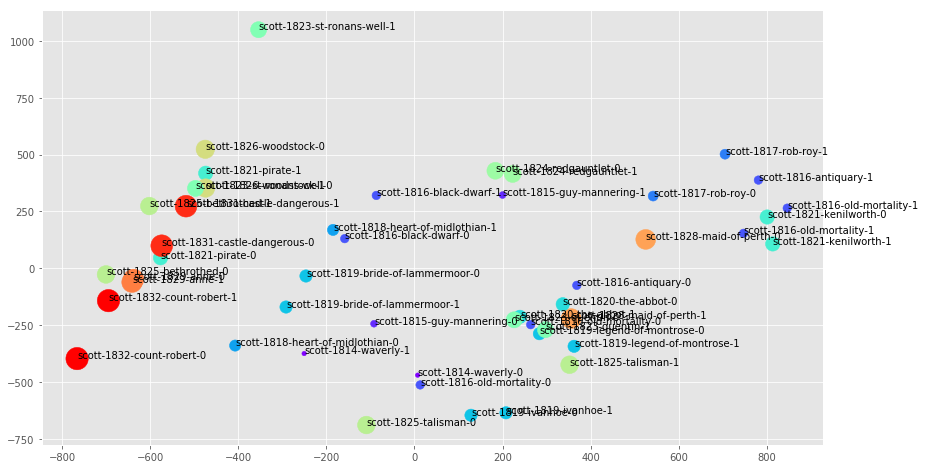

In [24]:
df = t.doPCA(labels=True)
df

# Charles Dickens

In [25]:
textList = glob('data/dickens*')
t = TextComparison(textList)
textList

['data/dickens-1839-oliver-twist.txt',
 'data/dickens-1865-our-mutual-friend.txt',
 'data/dickens-1859-a-tale-of-two-cities.txt',
 'data/dickens-1850-david-copperfield.txt',
 'data/dickens-1861-great-expectations.txt',
 'data/dickens-1870-the-mystery-of-edwin-drood.txt',
 'data/dickens-1848-dombey-and-son.txt',
 'data/dickens-1841-the-old-curiosity-shop.txt',
 'data/dickens-1854-hard-times.txt',
 'data/dickens-1844-martin-chuzzlewit.txt',
 'data/dickens-1857-little-dorrit.txt',
 'data/dickens-1841-barnaby-rudge.txt',
 'data/dickens-1837-the-pickwick-papers.txt',
 'data/dickens-1839-nicholas-nickleby.txt',
 'data/dickens-1853-bleak-house.txt']

,0,1,distance
dickens-1854-hard-times-1,1271.034840,2218.952967,2557.201954
dickens-1854-hard-times-0,1092.526295,2249.074311,2500.389762
dickens-1861-great-expectations-1,1799.528701,-658.096758,1916.088435
dickens-1861-great-expectations-0,1642.802360,-684.903022,1779.857226
dickens-1853-bleak-house-1,1553.506626,-776.504789,1736.762080


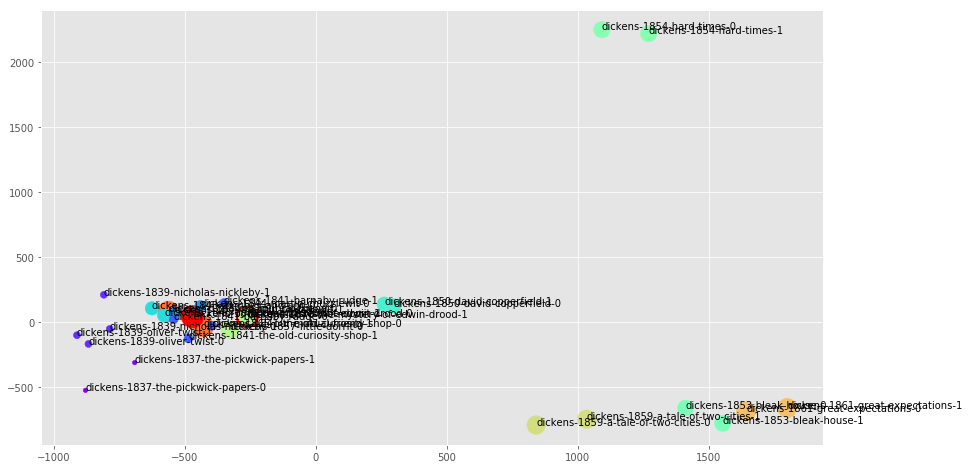

In [26]:
df = t.doPCA(labels=True)
df

# Willa Cather

In [27]:
textList = glob('data/cather*')
t = TextComparison(textList)
textList

['data/cather-1923-a-lost-lady.txt',
 'data/cather-1927-death-comes-for-the-archbishop.txt',
 'data/cather-1940-sapphira-and-the-slave-girl.txt',
 'data/cather-1915-the-song-of-the-lark.txt',
 'data/cather-1912-alexanders-bridge.txt',
 'data/cather-1935-lucy-gayheart.txt',
 'data/cather-1913-o-pioneers.txt',
 'data/cather-1918-my-ántonia.txt',
 'data/cather-1931-shadows-on-the-rock.txt',
 'data/cather-1925-the-professors-house.txt',
 'data/cather-1926-my-mortal-enemy.txt',
 'data/cather-1922-one-of-ours.txt']

,0,1,distance
cather-1927-death-comes-for-the-archbishop-0,231.510416,-95.846651,250.566664
cather-1912-alexanders-bridge-1,-205.490685,-128.083706,242.140161
cather-1931-shadows-on-the-rock-0,230.910182,19.769101,231.754891
cather-1926-my-mortal-enemy-1,-228.179881,-11.996383,228.495014
cather-1940-sapphira-and-the-slave-girl-0,-50.311710,181.835163,188.667153


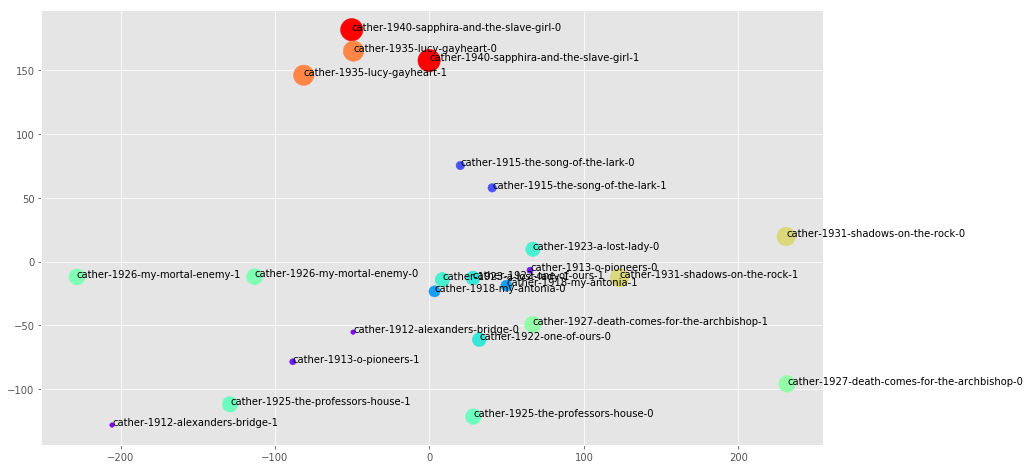

In [28]:
df = t.doPCA(labels=True)
df

# George Meredith 

In [29]:
textList = glob('data/meredith*')
t = TextComparison(textList)
textList

['data/meredith-1877-the-case-of-general-ople-and-lady-camper.txt',
 'data/meredith-1895-the-amazing-marriage.txt',
 'data/meredith-1880-the-tragic-comedians.txt',
 'data/meredith-1861-evan-harrington.txt',
 'data/meredith-1877-the-house-on-the-beach.txt',
 'data/meredith-1871-the-adventures-of-harry-richmond.txt',
 'data/meredith-1859-the-ordeal-of-richard-feverel.txt',
 'data/meredith-1910-celt-and-saxon.txt',
 'data/meredith-1864-emilia-in-england.txt',
 'data/meredith-1879-the-tale-of-chloe.txt',
 'data/meredith-1856-the-shaving-of-shagpat.txt',
 'data/meredith-1857-farina.txt',
 'data/meredith-1885-diana-of-the-crossways.txt',
 'data/meredith-1867-vittoria.txt',
 'data/meredith-1879-the-egoist.txt',
 'data/meredith-1891-one-of-our-conquerors.txt',
 'data/meredith-1865-rhoda-fleming.txt',
 'data/meredith-1894-lord-ormont-and-his-aminta.txt',
 'data/meredith-1875-beauchamps-career.txt']

,0,1,distance
meredith-1856-the-shaving-of-shagpat-1,469.875705,224.152468,520.603022
meredith-1856-the-shaving-of-shagpat-0,404.175379,230.485803,465.275662
meredith-1877-the-house-on-the-beach-1,-310.171929,42.648531,313.090279
meredith-1865-rhoda-fleming-1,-269.253450,157.141401,311.754455
meredith-1859-the-ordeal-of-richard-feverel-1,-291.536054,61.514307,297.955165


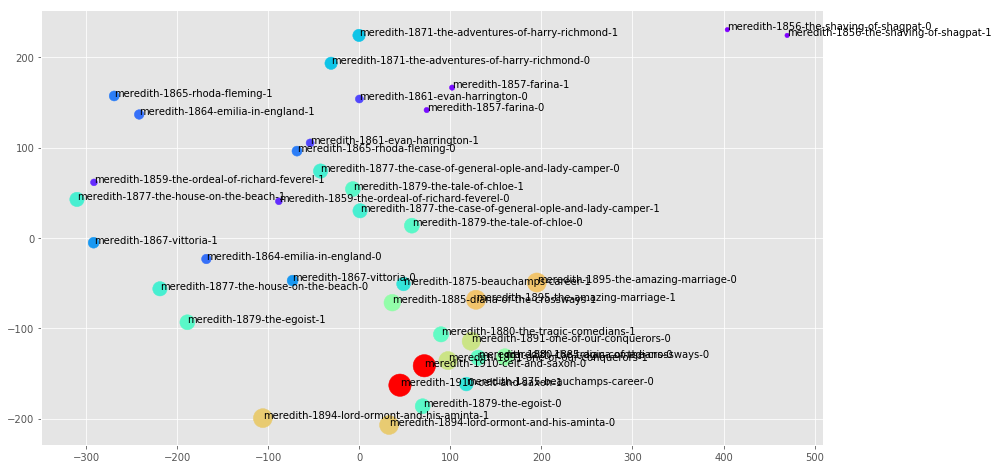

In [30]:
df = t.doPCA(labels=True)
df

# Joseph Conrad

In [31]:
textList = glob('data/conrad*')
t = TextComparison(textList)
textList

['data/conrad-1897-the-nigger-of-the-narcissus.txt',
 'data/conrad-1907-the-secret-agent.txt',
 'data/conrad-1911-under-western-eyes.txt',
 'data/conrad-1895-almayers-folly.txt',
 'data/conrad-1900-lord-jim.txt',
 'data/conrad-1902-typhoon.txt',
 'data/conrad-1920-the-rescue.txt',
 'data/conrad-1919-the-arrow-of-gold.txt',
 'data/conrad-1925-suspense.txt',
 'data/conrad-1896-an-outcast-of-the-islands.txt',
 'data/conrad-1899-heart-of-darkness.txt',
 'data/conrad-1913-chance.txt',
 'data/conrad-1923-the-rover.txt',
 'data/conrad-1902-the-end-of-the-tether.txt',
 'data/conrad-1917-the-shadow-line.txt',
 'data/conrad-1904-nostromo.txt',
 'data/conrad-1915-victory.txt']

,0,1,distance
conrad-1904-nostromo-0,592.514997,253.415703,644.432728
conrad-1919-the-arrow-of-gold-1,-558.160780,53.100014,560.680897
conrad-1917-the-shadow-line-0,-518.430499,131.287116,534.795745
conrad-1895-almayers-folly-0,524.877182,-55.002460,527.751198
conrad-1904-nostromo-1,460.254331,242.720993,520.334056


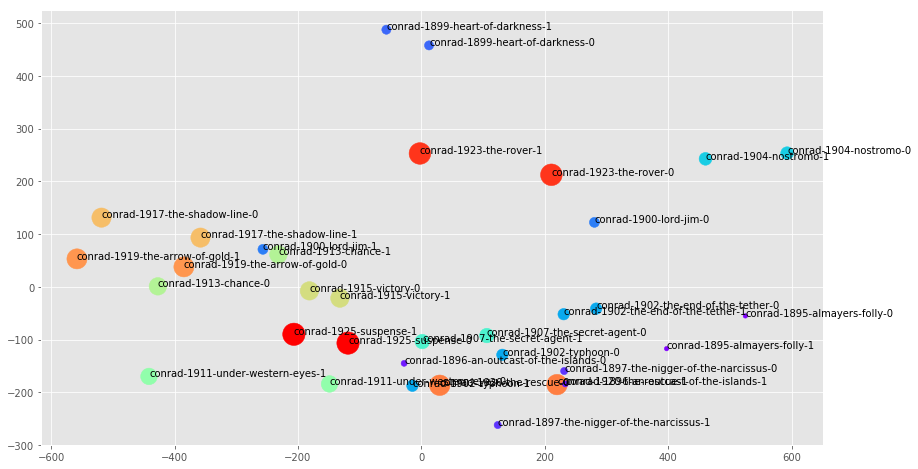

In [32]:
df = t.doPCA(labels=True)
df

# Jean Genet

In [33]:
textList = glob('data/genet*')
t = TextComparison(textList)
textList

['data/genet-1986-captif-amoreux.txt',
 'data/genet-1947-pompes-funèbres.txt',
 'data/genet-1949-journal-du-voleur.txt',
 'data/genet-1947-querelle-de-brest.txt',
 'data/genet-1946-miracle-de-la-rose.txt',
 'data/genet-1942-notre-dame.txt']

,0,1,distance
genet-1986-captif-amoreux-1,1974.868125,-11.667728,1974.902592
genet-1986-captif-amoreux-0,1884.846172,-80.660954,1886.571303
genet-1942-notre-dame-0,-203.910840,846.561123,870.772855
genet-1942-notre-dame-1,-278.196147,774.088522,822.560718
genet-1949-journal-du-voleur-1,-574.217836,-531.655056,782.549182


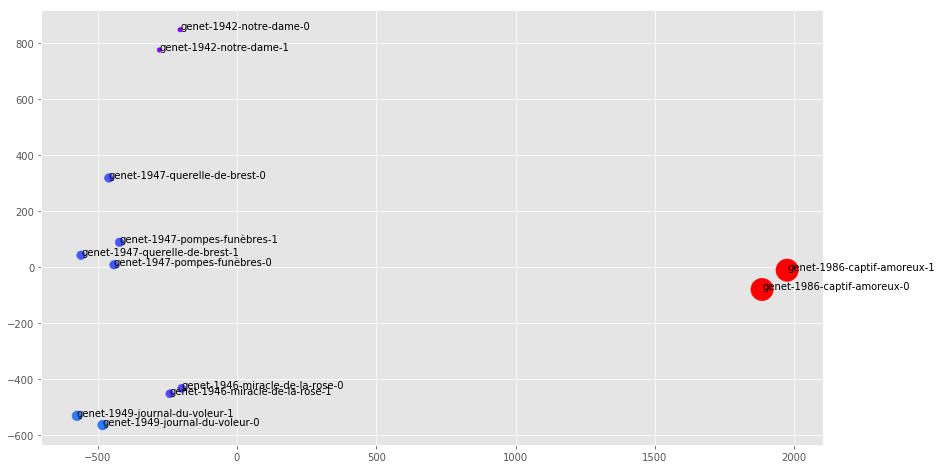

In [34]:
df = t.doPCA(labels=True)
df

# Henry James

In [36]:
textList = glob('data/james*')
t = TextComparison(textList)
textList

['data/james-1875-roderick-hudson.txt',
 'data/james-1877-the-american.txt',
 'data/james-1878-the-europeans.txt',
 'data/james-1886-princess-casamassima.txt',
 'data/james-1897-spoils-poynton.txt',
 'data/james-1881-portrait-of-a-lady.txt',
 'data/james-1911-outcry.txt',
 'data/james-1904-golden-bowl.txt',
 'data/james-1901-sacred-found.txt',
 'data/james-1871-watch-and-ward.txt',
 'data/james-1880-washington-square.txt',
 'data/james-1886-bostonians.txt',
 'data/james-1902-wings-of-the-dove.txt',
 'data/james-1899-awkward-age.txt',
 'data/james-1917-ivory-tower.txt',
 'data/james-1897-what-maisie-knew.txt',
 'data/james-1903-ambassadors.txt',
 'data/james-1879-confidence.txt',
 'data/james-1890-tragic-muse.txt',
 'data/james-1888-reverberator.txt']

,0,1,distance
james-1899-awkward-age-1,1365.867641,-413.504271,1427.088013
james-1911-outcry-0,1419.785990,-80.771879,1422.081698
james-1911-outcry-1,1370.935925,5.254123,1370.945993
james-1888-reverberator-1,1143.051153,-613.465954,1297.268829
james-1899-awkward-age-0,1219.482492,-404.127565,1284.700992


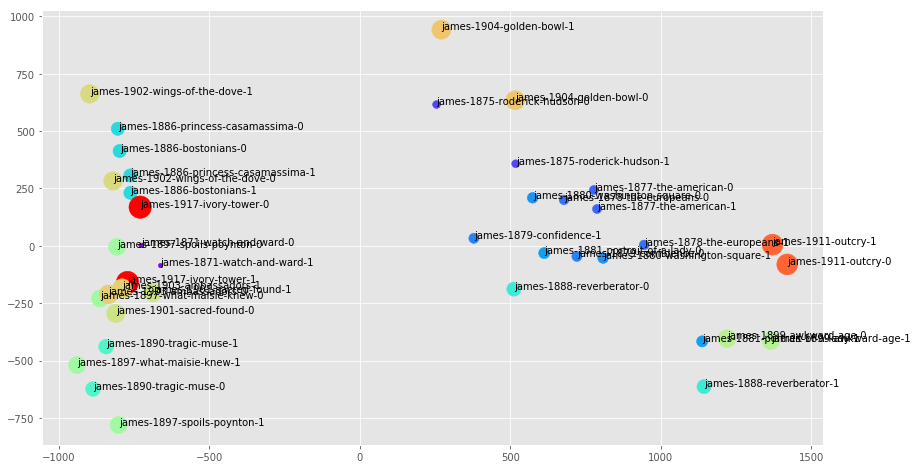

In [37]:
df = t.doPCA(labels=True)
df

# Ernest Hemingway

In [10]:
textList = glob('data/hemingway*')
t = TextComparison(textList)
textList

['data/hemingway-1926-torrents-spring.txt',
 'data/hemingway-1986-garden-of-eden.txt',
 'data/hemingway-1937-to-have-and-have.txt',
 'data/hemingway-1926-sun-also-rises.txt',
 'data/hemingway-1940-for-whom-the-bell.txt',
 'data/hemingway-1952-old-man-and-the-sea.txt',
 'data/hemingway-1936-short-happy.txt',
 'data/hemingway-1929-farewell-to-arms.txt',
 'data/hemingway-1950-across-the-river.txt',
 'data/hemingway-1970-islands-in-the-stream.txt']

,0,1,distance
hemingway-1940-for-whom-the-bell-1,777.578002,-310.753087,837.373890
hemingway-1940-for-whom-the-bell-0,732.158857,-359.839646,815.807062
hemingway-1952-old-man-and-the-sea-1,470.000746,483.108013,674.013393
hemingway-1952-old-man-and-the-sea-0,300.983285,424.574633,520.436891
hemingway-1926-sun-also-rises-1,-354.193971,-331.715049,485.271308


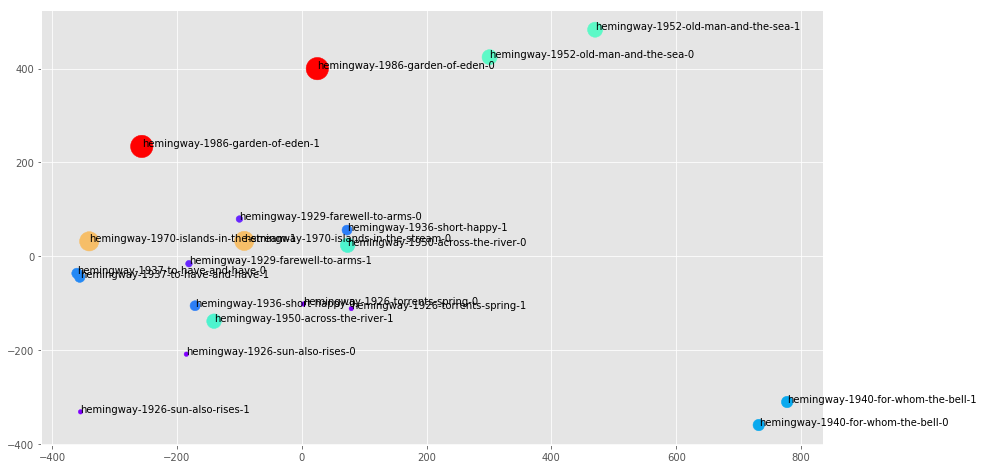

In [11]:
df = t.doPCA(labels=True)
df